In [2]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [47]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [48]:
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.renameArguments(ARG0='x')

In [49]:
#Adding extra primitives
pset.addPrimitive(np.abs, arity=1)
pset.addPrimitive(np.square, arity=1)

In [89]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [92]:
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
    return (np.sqrt(np.sum(sqerrors) / len(points)),)

In [93]:
toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [94]:
#added mutation for node replacement
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)

In [95]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [98]:
gen = range(40)
avg_list = []
max_list = []
min_list = []

pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 0.1867771781656091
  Max 17.05407165181457
  Avg 1.0374283940727602
  Std 0.9997347395628614
-- Generation 1 --
  Min 0.1867771781656091
  Max 3.0134642620509826
  Avg 0.8304145373431275
  Std 0.3434485812718547
-- Generation 2 --
  Min 0.1867771781656091
  Max 3.0769799950998937
  Avg 0.686094392609507
  Std 0.3549877978219753
-- Generation 3 --
  Min 0.0629625739108823
  Max 3.8722114073204303
  Avg 0.6096087239348336
  Std 0.3918752516673317
-- Generation 4 --
  Min 0.0629625739108823
  Max 5.455774984259528
  Avg 0.6128208108760437
  Std 0.5494381266567612
-- Generation 5 --
  Min 0.0629625739108823
  Max 3.7123255652741807
  Avg 0.5226014301255762
  Std 0.42887592765135196
-- Generation 6 --
  Min 0.0629625739108823
  Max 33.44590690454261
  Avg 0.7690514585801344
  Std 1.987777328254251
-- Generation 7 --
  Min 0.0629625739108823
  Max 5.451825827253303
  Avg 0.5743737146099598
  Std 0.618761293675431
-- Generation 8 --
  Min 0.0629625739108823
  Max 50.2

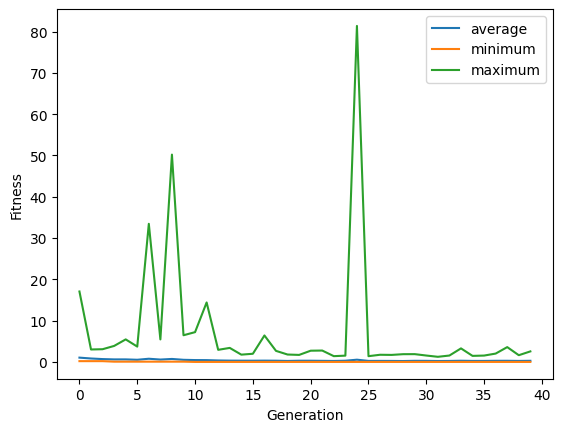

In [99]:
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()